In [1]:
# Загружаем библиотеки
import pandas as pd # Датафреймы pandas
import numpy as np # Математика
import matplotlib.pyplot as plt # Графики
from sklearn.linear_model import LinearRegression # Линейная регрессия
from sklearn.metrics import mean_absolute_error # Средняя абсолютная погрешность

# Фиксируем начальное условие для генератора случайных чисел
np.random.seed(42)

#### Датасет

In [2]:
# Создадим датасет, каждая строка представляет собой одно бронирование на авиарейс
# В каждом бронировании может быть несколько мест.
data = pd.DataFrame()
# Количество строк
n = 1000

# Предположим зависимость цены на авиабилеты от следующих данных:
# - расстояние в километрах (минимальное 200 км - как на автобусе, максимальное 20000 км - половина длины экватора Земли)
data['distance'] = np.random.randint(200, 20001, size = n)
# - количество мест (минимальное 1 человек, максимальное 35 - это школьный класс полным составом)
data['seats'] = np.random.randint(1, 36, size = n)
# - суммарный вес багажа в килограммах для всех пассажиров в одном бронировании
#  (минимальное 0 - без багажа, максимальное 35 кг - большой чемодан)
data['baggage'] = data['seats'].apply(lambda x: sum(np.random.randint(0, 36, size = x)))

# Цена не зависит от следующих данных:
# - максимальный вес пассажиров в килограммах для всех пассажиров в одном бронировании
# (на каждого пассажира: минимальное 20 кг - ребёнок, максимальное 150 кг)
data['max_weight'] = data['seats'].apply(lambda x: max(np.random.randint(20, 150, size = x)))
# - средний рост пассажиров в сантиметрах
# (на каждого пассажира: минимальное 100 см - ребёнок, максимальное 200 см)
data['mean_height'] = data['seats'].apply(lambda x: int(sum(np.random.randint(100, 200, size = x)/x)))

# Добавим выбросы
data.loc[np.random.randint(0, (n + 1)), 'distance'] = 100000
data.loc[np.random.randint(0, (n + 1)), 'seats'] = 100000
data.loc[np.random.randint(0, (n + 1)), 'baggage'] = 100000
data.loc[np.random.randint(0, (n + 1)), 'max_weight'] = 100000
data.loc[np.random.randint(0, (n + 1)), 'mean_height'] = 100000                           

# Коэффициенты для расчёта стоимости бронирования
coef_1 = 1
coef_2 = 100
bias = 1000
# Стоимость бронирования в условных единицах денег
data['cost'] = coef_1 * data['distance'] * data['seats'] + coef_2 * data['baggage'] + bias

#### Результаты без обработки данных

In [3]:
# Матрица признаков
X = data[data.columns[:-1]]
# Вектор целевых значений
y = data['cost']

# Используем линейную регрессию
model = LinearRegression()
model.fit(X, y)
# Результаты
print('Коэффициенты: {}'.format(model.coef_))
print('Смещение: {}'.format(model.intercept_))
print(f'Погрешность: {mean_absolute_error(model.predict(X), y)}')
print('Погрешность очень большая, нужно исследовать данные!')

Коэффициенты: [ 1.69533216e+01  1.54020096e+04  9.89885663e+01 -1.20437256e+00
 -1.72402632e-01]
Смещение: -265925.71086904965
Погрешность: 58102.790100428865
Погрешность очень большая, нужно исследовать данные!


#### Поиск выбросов

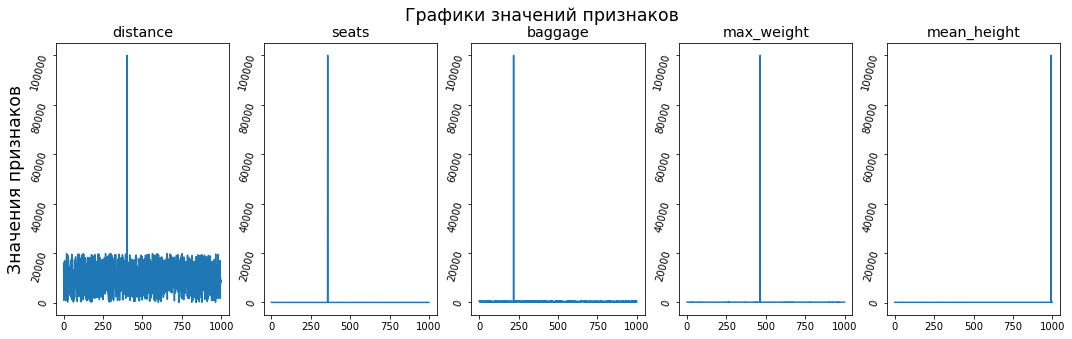

Выбросы присутствуют в виде пиков. Так как выбросов относительно мало (по сравнению с общим количеством строк), то удали строки с выбросами.


In [4]:
# Построим графики каждого признака и посмотрим есть ли выбросы

fig, axes = plt.subplots(nrows = 1, # Одна строка с графиками
                         ncols = 5, # В строке 5 графиков
                         figsize=(18, 5), # Размер общего поля
                        ) 

i = 0
for feature in data.columns[:-1]:
    axes[i].plot(data[feature])
    axes[i].set_title(feature, fontsize = 'x-large')
    axes[i].tick_params(axis = 'y', labelrotation = 75)
    i += 1


# Общая надпись    
fig.suptitle('Графики значений признаков', fontsize = 'xx-large')  
# Надпись по вертикальной оси
axes[0].set_ylabel('Значения признаков', fontsize = 'xx-large')

plt.show()

print('Выбросы присутствуют в виде пиков. Так как выбросов относительно мало (по сравнению с общим количеством строк), то удали строки с выбросами.')

In [5]:
# Найдём и удалим строки с выбросами
data = data.drop(index = data[data['distance'] > 20000].index)
data = data.drop(index = data[data['seats'] > 35].index)
data = data.drop(index = data[data['baggage'] > (35 * 35)].index)
data = data.drop(index = data[data['max_weight'] > 150].index)
data = data.drop(index = data[data['mean_height'] > 200].index)

#### Графики корелляции

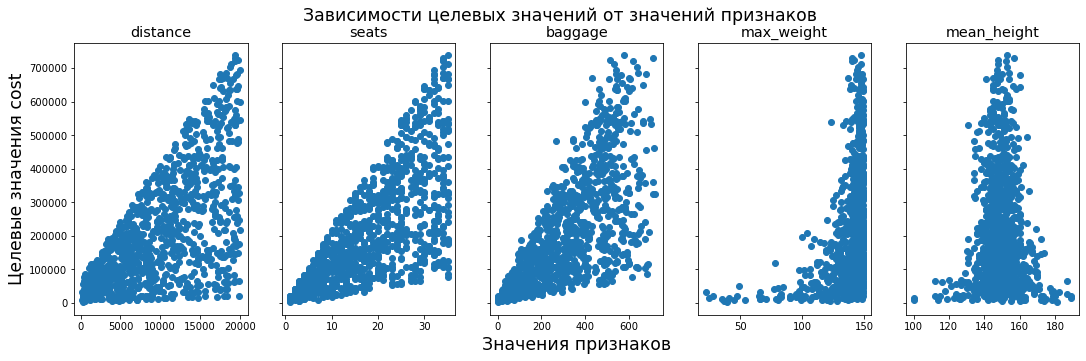

Графики показывают наличие зависимости целевых значений от признков distance, seats, baggage
Зависимость целевых значений от признаков max_weight и mean_height низкая (по сравнению с остальными признаками), отбросим их


In [6]:
# Построим графики зависимостей целевых значений от всех остальных признаков

fig, axes = plt.subplots(nrows = 1, # Одна строка с графиками
                         ncols = 5, # В строке 5 графиков
                         figsize=(18, 5), # Размер общего поля
                         sharey = 'all' # Делаем вертикальную ось общей для всех графиков
                        ) 

i = 0
for feature in data.columns[:-1]:
    axes[i].scatter(data[feature], data['cost'])
    axes[i].set_title(feature, fontsize = 'x-large')
    i += 1


# Общая надпись    
fig.suptitle('Зависимости целевых значений от значений признаков', fontsize = 'xx-large')  
# Надпись по вертикальной оси
axes[0].set_ylabel('Целевые значения cost', fontsize = 'xx-large')
# Надпись по горизонтальной оси (присваиваем среднему графику для расположения по центру)
axes[2].set_xlabel('Значения признаков', fontsize = 'xx-large')  

plt.show()

print('Графики показывают наличие зависимости целевых значений от признков distance, seats, baggage')
print('Зависимость целевых значений от признаков max_weight и mean_height низкая (по сравнению с остальными признаками), отбросим их')

#### Результаты после отбрасывания нескольких признаков

In [7]:
# Матрица признаков
X = data[['distance', 'seats', 'baggage']]
# Вектор целевых значений
y = data['cost']

# Используем линейную регрессию
model = LinearRegression()
model.fit(X, y)
# Результаты
print('Коэффициенты: {}'.format(model.coef_))
print('Смещение: {}'.format(model.intercept_))
print(f'Погрешность: {mean_absolute_error(model.predict(X), y)}')
print('Погрешность немного уменьшилась')

Коэффициенты: [   18.27047515 11438.35036479    16.88323332]
Смещение: -180360.0518030892
Погрешность: 43625.83828205553
Погрешность немного уменьшилась


#### Создание новых признаков

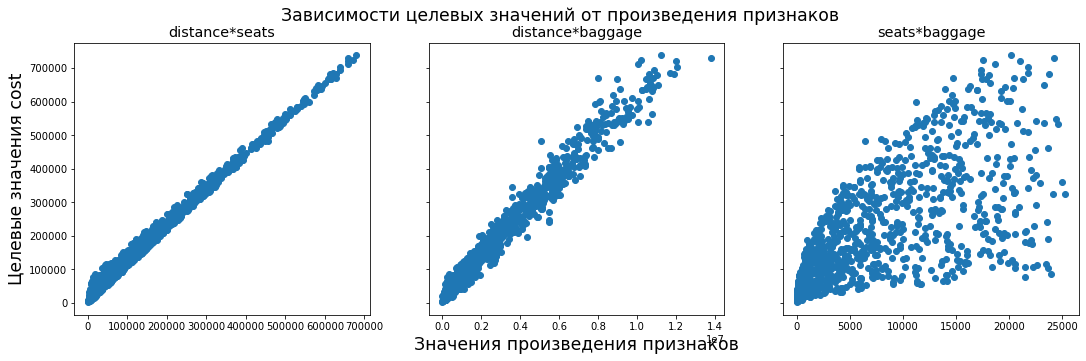

Графики показывают наличие зависимости целевых значений от произведения признаков
Наибольшая зависимость для distance*seats, средняя для distance*baggage наименьшая для seats*baggage
Построим модели с использованием произведения признаков


In [8]:
# Перемножим признаки попарно и построим графики корелляции
X = pd.concat([(data['distance'] * data['seats']), (data['distance'] * data['baggage']), (data['seats'] * data['baggage'])], axis=1)
X.rename(columns = {0: 'distance*seats', 1: 'distance*baggage', 2: 'seats*baggage'}, inplace = True)

# Построим графики зависимостей целевых значений от произведений признаков
fig, axes = plt.subplots(nrows = 1, # Одна строка с графиками
                         ncols = 3, # В строке 3 графиков
                         figsize=(18, 5), # Размер общего поля
                         sharey = 'all' # Делаем вертикальную ось общей для всех графиков
                        ) 

i = 0
for feature in X.columns:
    axes[i].scatter(X[feature], y)
    axes[i].set_title(feature, fontsize = 'x-large')
    i += 1


# Общая надпись    
fig.suptitle('Зависимости целевых значений от произведения признаков', fontsize = 'xx-large')  
# Надпись по вертикальной оси
axes[0].set_ylabel('Целевые значения cost', fontsize = 'xx-large')
# Надпись по горизонтальной оси (присваиваем среднему графику для расположения по центру)
axes[1].set_xlabel('Значения произведения признаков', fontsize = 'xx-large')  

plt.show()

print('Графики показывают наличие зависимости целевых значений от произведения признаков')
print('Наибольшая зависимость для distance*seats, средняя для distance*baggage наименьшая для seats*baggage')
print('Построим модели с использованием произведения признаков')

#### Модель с использованием произведения признаков distance*seats

In [9]:
# Матрица признаков
X = pd.concat([(data['distance'] * data['seats']), data['baggage']], axis=1)
# Вектор целевых значений
y = data['cost']

# Используем линейную регрессию
model = LinearRegression()
model.fit(X, y)
# Результаты
print('Коэффициенты: {}'.format(model.coef_))
print('Смещение: {}'.format(model.intercept_))
print(f'Погрешность: {mean_absolute_error(model.predict(X), y)}')
print('Лучший результат! Погрешность минимальная, коэффициенты модели равны исходным')

Коэффициенты: [  1. 100.]
Смещение: 1000.0000000000291
Погрешность: 1.9646913688349064e-11
Лучший результат! Погрешность минимальная, коэффициенты модели равны исходным


#### Модель с использованием произведения признаков distance*baggage

In [10]:
# Матрица признаков
X = pd.concat([(data['distance'] * data['baggage']), data['seats']], axis=1)
# Вектор целевых значений
y = data['cost']

# Используем линейную регрессию
model = LinearRegression()
model.fit(X, y)
# Результаты
print('Коэффициенты: {}'.format(model.coef_))
print('Смещение: {}'.format(model.intercept_))
print(f'Погрешность: {mean_absolute_error(model.predict(X), y)}')
print('Результат неудовлетворительный, высокая погрешность!')

Коэффициенты: [5.49221001e-02 2.22180238e+03]
Смещение: 22.101676616061013
Погрешность: 15802.472024528775
Результат неудовлетворительный, высокая погрешность!


#### Модель с использованием произведения признаков seats*baggage

In [11]:
# Матрица признаков
X = pd.concat([(data['seats'] * data['baggage']), data['distance']], axis=1)
# Вектор целевых значений
y = data['cost']

# Используем линейную регрессию
model = LinearRegression()
model.fit(X, y)
# Результаты
print('Коэффициенты: {}'.format(model.coef_))
print('Смещение: {}'.format(model.intercept_))
print(f'Погрешность: {mean_absolute_error(model.predict(X), y)}')
print('Результат неудовлетворительный, высокая погрешность!')

Коэффициенты: [16.75022898 18.37871359]
Смещение: -95128.05030851852
Погрешность: 53057.96107847537
Результат неудовлетворительный, высокая погрешность!


### Выводы:
- нашли выбросы и отбросили стрки с ними
- посмотрели корелляции и отбросили лишние признаки для упрощения дальнейшей работы с моделью
- перемножили признаки попарно и получили модель с искомыми коэффициентами и околонулевой погрешностью